# CMIP6 Correlation Matrix

**Following steps are included in this script:**

1. Load netCDF files
2. Compute regional variable correlations
3.  Plot Heatmap

## Import Packages

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import regionmask

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
data_vis_dir = '/work/ch0636/g300115/phd_project/common/src/visualization'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)
sys.path.append(data_vis_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as load_dat
import process_data as pro_dat
import compute_statistics as comp_stats
import colormaps as colmap
import parallel_coordinate_plots as par_coor_plot

from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

In [2]:
importlib.reload(load_dat)
importlib.reload(pro_dat)
importlib.reload(comp_stats)
importlib.reload(colmap)
importlib.reload(par_coor_plot)

<module 'parallel_coordinate_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/parallel_coordinate_plots.py'>

In [3]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, textcomp}'

# For color map
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

#Check all possible fonts
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# Set the font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]

## 1. Load and Preprocess

### 1.1 Load Data

In [4]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical', 'ssp370']
models = ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']

variables=['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue', 'RX5day', 'gsl'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(load_dat.load_period_mean(BASE_DIR, data_state, data_product, experiments, models, variables, specific_months_or_seasons=None))[0]

Loading 'month' resolution variables ['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'historical'...
Selecting period 1985-2014 for 'month' variables in experiment 'historical'...
Computing period mean for 'month' variables in experiment 'historical'...
Loading 'year' resolution variable 'RX5day' for experiment 'historical'...
Computing period mean for 'year' variable in experiment 'historical'...
Loading 'period_mean' resolution variable 'gsl' for experiment 'historical'...
Merging all datasets for experiment 'historical'...
Loading 'month' resolution variables ['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'ssp370'...
Selecting period 2071-2100 for 'month' variables in experiment 'ssp370'...
Computing period mean for 'month' variables in experiment 'ssp370'...
Loading 'year' resolution variable 'RX5day' for experiment 'ssp370'...
Computing period mean for 'year' variable in expe

### 1.2 Compute Historical BGWS and Ensemble statsitics

In [5]:
ds_dict = pro_dat.compute_bgws(ds_dict)

In [6]:
ds_dict = pro_dat.compute_tbgw(ds_dict)

In [7]:
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'mean')
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


In [8]:
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'mean')
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


### 1.3 Compute Changes and Ensemble statsitics

In [9]:
ds_dict_change = pro_dat.compute_change_dict(ds_dict)

Ensemble mean or median removed for keys: ['Ensemble mean', 'Ensemble median']


In [10]:
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'mean')
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


### 1.4 Divide Data into Regions and Subdregions

In [11]:
ds_dict_region = {}
ds_dict_region = pro_dat.apply_region_mask(ds_dict, with_global=True)

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300115/.conda/envs/mypy3/share/proj failed


In [12]:
ds_dict_region_sub = {}
ds_dict_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                              ds_dict_region['historical'],  
                                                              'historical', 'historical', 'bgws')

In [13]:
ds_dict_change_region = {}
ds_dict_change_region = pro_dat.apply_region_mask(ds_dict_change, with_global=True)

In [14]:
ds_dict_change_region_sub = {}
ds_dict_change_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                              ds_dict_change_region['ssp370-historical'],  
                                                              'historical', 'ssp370-historical', 'bgws')

### 1.5 Compute Regional Means

In [15]:
ds_dict_region_mean = {}
ds_dict_region_mean = comp_stats.compute_regional_means(ds_dict_region)

In [16]:
ds_dict_region_sub_mean = {}
ds_dict_region_sub_mean = comp_stats.compute_spatial_mean_with_subdivisions(ds_dict_region_sub)

In [17]:
ds_dict_change_region_mean = {}
ds_dict_change_region_mean = comp_stats.compute_regional_means(ds_dict_change_region)

In [18]:
ds_dict_change_region_sub_mean = {}
ds_dict_change_region_sub_mean = comp_stats.compute_spatial_mean_with_subdivisions(ds_dict_change_region_sub)

## 2. Plot Heatmaps

In [340]:
importlib.reload(par_coor_plot)

<module 'parallel_coordinate_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/parallel_coordinate_plots.py'>

### 2.1 Heatmaps of subregional analysis

In [333]:
ds_dict_change_region_mean['ssp370-historical']['Ensemble mean']

<xarray.Dataset>
Dimensions:  (region: 44)
Coordinates:
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 ... 36 37 38 39 40 41 42 43 0
    abbrevs  (region) <U4 'NWN' 'NEN' 'WNA' 'CNA' ... 'EAU' 'SAU' 'NZ' 'glob'
    names    (region) <U22 'N.W.North-America' 'N.E.North-America' ... 'Global'
Data variables: (12/15)
    tas      (region) float64 5.936 6.923 4.536 4.923 ... 3.187 2.727 4.456
    pr       (region) float64 0.3809 0.3297 0.07491 ... -0.09965 0.1551 0.1257
    vpd      (region) float64 0.7808 0.8734 2.818 3.798 ... 2.848 0.592 3.315
    evspsbl  (region) float64 0.1572 0.1811 0.0936 ... 0.005483 0.0913 0.0685
    evapo    (region) float64 0.11 0.1208 0.05086 ... 0.04093 0.1344 0.08923
    tran     (region) float64 0.04811 0.06149 0.04251 ... -0.05693 -0.02078
    ...       ...
    gpp      (region) float64 1.083 0.8611 0.9481 1.052 ... 0.6923 1.65 1.022
    wue      (region) float64 1.079 0.8901 1.071 1.127 ... 1.438 1.707 1.143
    RX5day   (region) float64 10.65 9.535 8.092 7.812 ... 12.01 4.838 11.8 12.58
    gsl      (region) float64 0.1535 0.1807 0.1915 ... 0.03652 -0.3073 0.1342
    bgws     (region) float64 0.5954 -1.604 -3.844 1.278 ... 0.0973 4.07 1.008
    tbgw     (region) float64 0.4859 0.8588 -0.6205 ... -0.3224 0.2414 0.3198
Attributes:
    description:    Ensemble mean
    computed_from:  ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'C...

#### Spearman

In [24]:
ds_dict_change_region_sub['ssp370-historical']['Ensemble mean']

<xarray.Dataset>
Dimensions:      (subdivision: 2, lat: 149, lon: 360, region: 44)
Coordinates:
  * subdivision  (subdivision) object 'Positive Historical BGWS' 'Negative Hi...
  * lat          (lat) int64 -59 -58 -57 -56 -55 -54 -53 ... 84 85 86 87 88 89
  * lon          (lon) int64 -180 -179 -178 -177 -176 ... 175 176 177 178 179
  * region       (region) int64 1 2 3 4 5 6 7 8 9 ... 36 37 38 39 40 41 42 43 0
    abbrevs      (region) <U4 'NWN' 'NEN' 'WNA' 'CNA' ... 'SAU' 'NZ' 'glob'
    names        (region) <U22 'N.W.North-America' ... 'Global'
Data variables: (12/15)
    tas          (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    pr           (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    vpd          (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    evspsbl      (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    evapo        (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    tran         (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    ...           ...
    gpp          (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    wue          (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    RX5day       (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    gsl          (subdivision, lat, lon, region) float64 nan nan nan ... nan nan
    bgws         (subdivision, lat, lon, region) float32 nan nan nan ... nan nan
    tbgw         (subdivision, lat, lon, region) float32 nan nan nan ... nan nan

In [19]:
def prepare_display_variables(variables):
    var_map = {
        'tas': ('T', '°C'),
        'vpd': ('VPD', 'hPa'),
        'gpp': ('GPP', r'\frac{\frac{gC}{m^2}}{day}'),  
        'pr': ('P', r'\frac{mm}{day}'),
        'mrro': ('R', r'\frac{mm}{day}'),
        'evspsbl': ('ET', r'\frac{mm}{day}'),
        'tran': ('Tran', r'\frac{mm}{day}'),
        'evapo': ('E', r'\frac{mm}{day}'),
        'lai': ('LAI', r'\frac{m^2}{m^2}'),
        'mrso': ('SM', '\%'),
        'rgtr': ('P/T', r'\frac{GPP}{T}'),
        'et_partitioning': ('EP', r'\frac{E-Tran}{ET}'),
        'RX5day': ('RX5day', 'mm'),
        'gsl': ('GSL', 'months'),
        'wue': ('WUE', r'\frac{\frac{mm}{gC}}{m^2}'),
        'bgws': ('BGWS', '\%'),
        'tbgw': ('TBGW', '\%')
    }
    display_variables = {}
    for var in variables:
        if var in var_map:
            abbreviation, units = var_map[var]
            display_variables[var] = f"${{\Delta\, \mathrm{{\it{{{abbreviation}}}}}}}$ \n $\\left[{units}\\right]$"
        else:
            print(f"Variable '{var}' not found in var_map.")
            display_variables[var] = var
    return display_variables

In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def plot_spearman_heatmap(ds_dict_change_region_sub, scenario, region, subdivision, variables, savepath=None):
    # Extract data for the specific scenario, region, and subdivision
    ds = ds_dict_change_region_sub[scenario]['Ensemble mean']
    
    # Initialize a list to hold data arrays for the selected variables
    data_arrays = []
    
    for var in variables:
        if var in ds.data_vars:
            # Extract the data for the chosen region and subdivision
            data = ds[var].sel(region=region, subdivision=subdivision)
            # Flatten the array and append it to the list (ignoring NaNs)
            data_arrays.append(data.values.flatten())
        else:
            print(f"Variable '{var}' not found in dataset.")
    
    # Create a DataFrame from the flattened arrays, ignoring NaN values
    df = pd.DataFrame(np.array(data_arrays).T, columns=variables).dropna()
    
    # Compute Spearman correlation matrix
    corr_matrix = df.corr(method='spearman')
    
    # Prepare display variable names using the function provided
    display_variables = prepare_display_variables(variables)
    display_names = [display_variables[var] for var in variables]
    
    # Create the heatmap
    plt.figure(figsize=(16, 12))
    
    # Use a more advanced-looking color palette and limit the color range
    heatmap = sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt='.2f', 
        cmap='coolwarm', 
        vmin=-1, 
        vmax=1, 
        annot_kws={"size": 14},  # Larger numbers
        xticklabels=display_names, 
        yticklabels=display_names, 
        cbar_kws={'label': 'Spearman Correlation'}  # Larger label with unit
    )
    
    # Set larger colorbar ticks and label
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(r'Spearman Rank Correlation $\rho$', size=16)
    
    # Rotate the y-axis labels for better readability
    plt.yticks(rotation=0, fontsize=14)
    plt.xticks(rotation=0, fontsize=14)
    
    # Improve the layout and make it tight
    plt.tight_layout()

    if savepath is not None:
        region_name = ds.isel(region=region).names.item()

        subdivision_name = subdivision.replace(" ", "_")

        sp = os.path.join(savepath, region_name)
    
        os.makedirs(sp, exist_ok=True)
    
        filename = f'{region_name}_{subdivision_name}_heatmap.pdf' 
    
        filepath = os.path.join(sp, filename)
        plt.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        print(f'Figure saved at: {filepath}')
    
    # Show the plot
    plt.show()

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/scatter_and_statistics/heatmaps/Global/Global_Negative_Historical_BGWS_heatmap.pdf


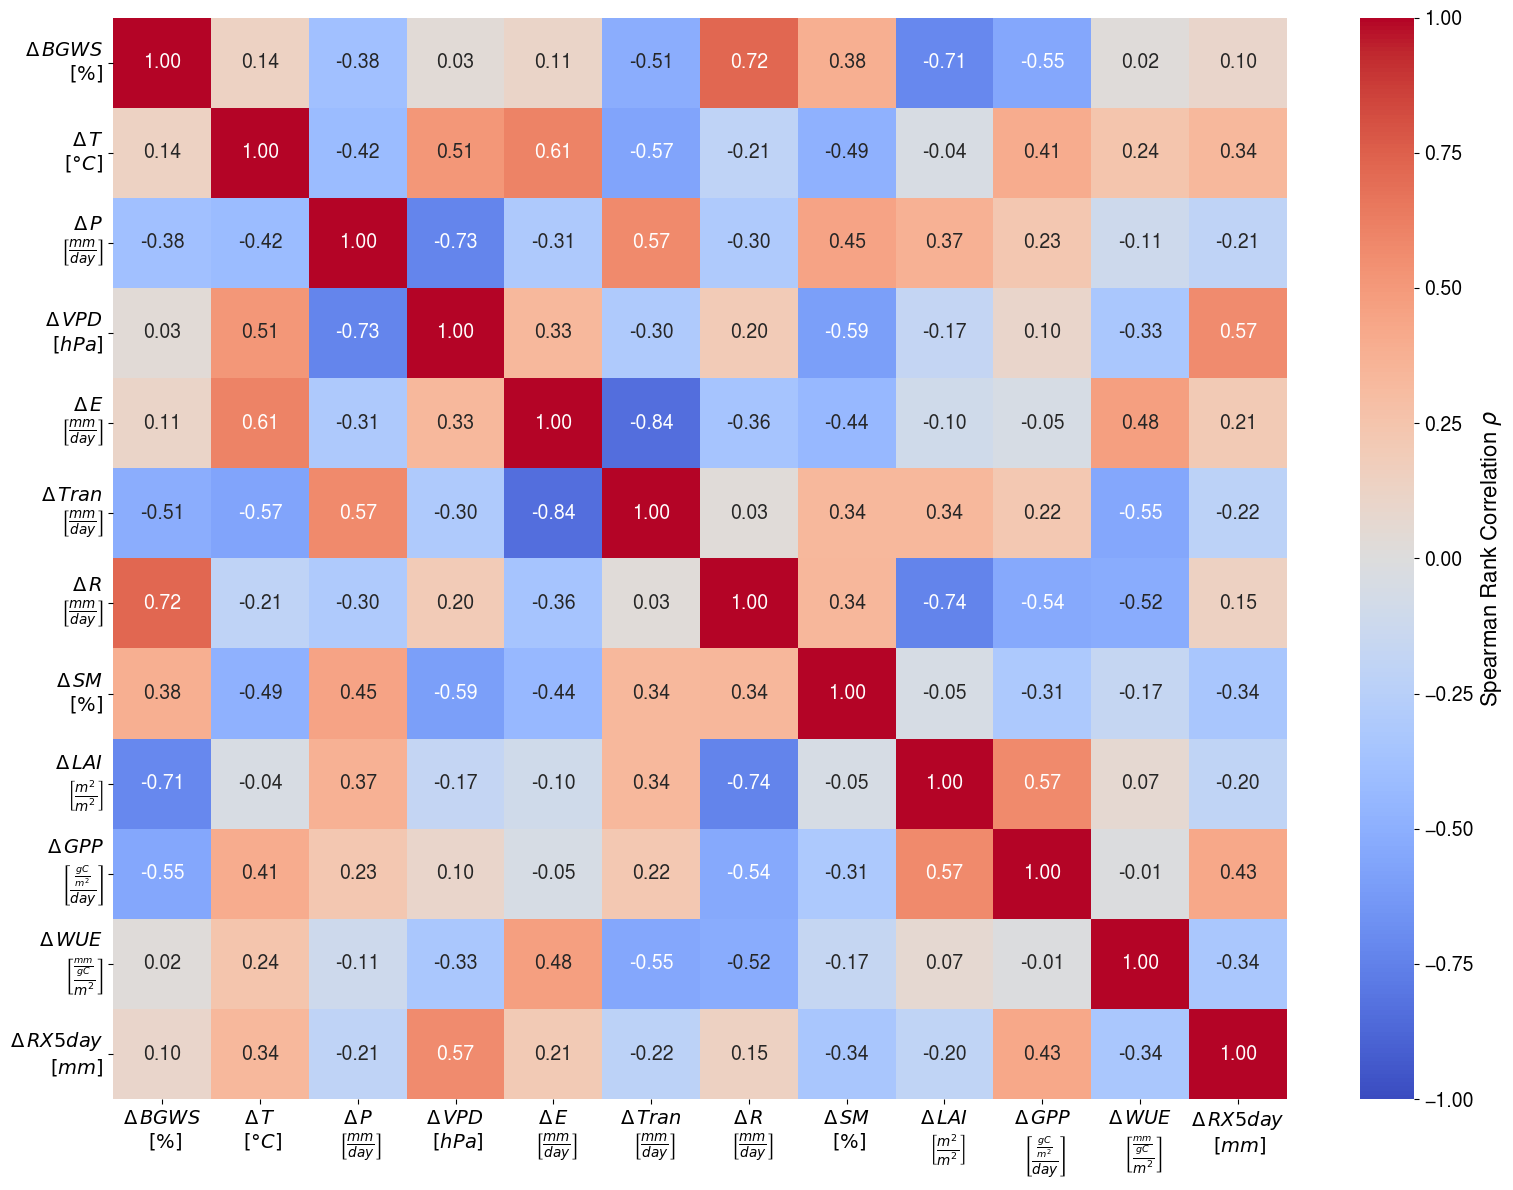

In [33]:
# regions 4 - pos, 9 - neg, 21 - neg, 24 - neg, 34 - pos, 40 - neg, 43 - pos and neg
variables_to_plot = ['bgws', 'tas', 'pr', 'vpd', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue', 'RX5day'] 
plot_spearman_heatmap(ds_dict_change_region_sub, 'ssp370-historical', region=43, 
                      subdivision='Negative Historical BGWS', variables=variables_to_plot,
                      savepath=f'/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/scatter_and_statistics/heatmaps/'
)